In [371]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from tqdm import tqdm
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv


In [372]:
df = pd.read_csv("../input/machine-predictive-maintenance-classification/predictive_maintenance.csv")

In [373]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [374]:
df = df.drop(["UDI", "Product ID","Target"], axis = 1)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


In [375]:
df.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Failure Type               0
dtype: int64

In [377]:
df["Type"] = df["Type"].replace("L",0)
df["Type"] = df["Type"].replace("M",1)
df["Type"] = df["Type"].replace("H",2)

In [378]:
df["Failure Type"] = df["Failure Type"].replace("No Failure", 0)
df["Failure Type"] = df["Failure Type"].replace("Tool Wear Failure", 1)
df["Failure Type"] = df["Failure Type"].replace("Heat Dissipation Failure", 1)
df["Failure Type"] = df["Failure Type"].replace("Power Failure", 1)
df["Failure Type"] = df["Failure Type"].replace("Overstrain Failure", 1)
df["Failure Type"] = df["Failure Type"].replace("Random Failures", 1)


In [379]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,1,298.1,308.6,1551,42.8,0,0
1,0,298.2,308.7,1408,46.3,3,0
2,0,298.1,308.5,1498,49.4,5,0
3,0,298.2,308.6,1433,39.5,7,0
4,0,298.2,308.7,1408,40.0,9,0


In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Failure Type             10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


In [381]:
class CSVDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [382]:
class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(n_inputs, 10)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(10, 8)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(8, 1)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.hidden3(x)
        x = self.act3(x)
        return x

In [383]:
def prepare_data(path):
    df = read_csv(path)
    df = df.drop(["UDI", "Product ID", "Target"], axis=1)
    df["Type"] = df["Type"].replace(["L", "M", "H"], [0, 1, 2])
    df["Failure Type"] = df["Failure Type"].replace(
        ["No Failure", "Tool Wear Failure", "Heat Dissipation Failure",
         "Power Failure", "Overstrain Failure", "Random Failures"], [0, 1, 1, 1, 1, 1])

    train_data, test_data, train_labels, test_labels = train_test_split(
        df.drop(["Failure Type"], axis=1), df["Failure Type"], random_state=42)

    train_dataset = CSVDataset(train_data, train_labels)
    test_dataset = CSVDataset(test_data, test_labels)

    train_dl = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=512, shuffle=False)

    return train_dl, test_dl

In [384]:
def train_model(train_dl, model):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in tqdm(range(100), desc='Training Epochs'):
        print(f"Epoch {epoch+1}\n-------------------------------")
        for inputs, targets in train_dl:
            optimizer.zero_grad()
            yhat = model(inputs)
            targets = targets.unsqueeze(1)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()

            loss = loss.item()
            print(f"loss: {loss:>7f}")

In [385]:

def evaluate_model(test_dl, model):
    predictions, actuals = [], []
    for inputs, targets in test_dl:
        yhat = model(inputs)
        yhat = yhat.detach().numpy().round()
        actuals.extend(targets.numpy())
        predictions.extend(yhat)

    acc = accuracy_score(actuals, predictions)
    return acc


In [386]:
def predict(row, model):
    row = torch.tensor([row], dtype=torch.float32)
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat

In [387]:
path = "../input/machine-predictive-maintenance-classification/predictive_maintenance.csv"
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

# define the network
model = MLP(6)
# train the model
train_model(train_dl, model)

7500 2500


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 0.556662
loss: 2.625945
loss: 0.409385
loss: 0.442521
loss: 0.666601
loss: 0.132534


Training Epochs:   1%|          | 1/100 [00:00<00:11,  8.94it/s]

loss: 0.794686
loss: 0.240266
loss: 96.679688
loss: 96.679688
loss: 94.921875
loss: 95.312500
loss: 96.093750
loss: 96.093750
loss: 96.385544
Epoch 2
-------------------------------
loss: 96.484375
loss: 97.656250
loss: 96.875000
loss: 95.117188
loss: 96.679688
loss: 96.484375
loss: 96.289062
loss: 95.703125
loss: 97.851562
loss: 96.875000
loss: 95.312500
loss: 97.070312
loss: 96.289062
loss: 96.679688
loss: 93.072289
Epoch 3
-------------------------------
loss: 96.875000
loss: 94.335938


Training Epochs:   3%|▎         | 3/100 [00:00<00:08, 12.02it/s]

loss: 97.265625
loss: 96.875000
loss: 96.289062
loss: 94.726562
loss: 96.679688
loss: 96.484375
loss: 96.093750
loss: 97.265625
loss: 95.703125
loss: 97.265625
loss: 96.679688
loss: 95.898438
loss: 97.590363
Epoch 4
-------------------------------
loss: 97.070312
loss: 95.703125
loss: 94.726562
loss: 96.484375
loss: 95.703125
loss: 96.875000
loss: 96.289062
loss: 95.898438
loss: 96.093750
loss: 97.265625
loss: 97.656250
loss: 95.507812
loss: 97.265625
loss: 96.484375
loss: 96.686745
Epoch 5
-------------------------------
loss: 96.484375
loss: 96.289062
loss: 95.703125
loss: 96.289062
loss: 97.656250
loss: 97.851562
loss: 96.093750
loss: 97.265625
loss: 94.921875
loss: 96.093750
loss: 96.484375
loss: 95.117188
loss: 96.679688


Training Epochs:   5%|▌         | 5/100 [00:00<00:07, 12.44it/s]

loss: 96.093750
loss: 96.686745
Epoch 6
-------------------------------
loss: 96.679688
loss: 97.656250
loss: 96.093750
loss: 95.898438
loss: 95.312500
loss: 96.679688
loss: 96.093750
loss: 97.070312


Training Epochs:   7%|▋         | 7/100 [00:00<00:07, 12.78it/s]

loss: 97.265625
loss: 95.117188
loss: 96.289062
loss: 95.898438
loss: 96.875000
loss: 96.875000
loss: 95.481926
Epoch 7
-------------------------------
loss: 96.484375
loss: 97.265625
loss: 95.312500
loss: 97.070312
loss: 95.312500
loss: 97.070312
loss: 95.117188
loss: 98.046875
loss: 95.703125
loss: 95.507812
loss: 96.289062
loss: 96.875000
loss: 95.507812
loss: 97.460938
loss: 96.686745
Epoch 8
-------------------------------
loss: 96.875000
loss: 97.460938
loss: 96.875000
loss: 96.289062
loss: 95.507812
loss: 95.703125
loss: 96.093750
loss: 96.679688
loss: 97.070312
loss: 95.507812
loss: 95.312500
loss: 96.679688
loss: 96.484375
loss: 97.070312
loss: 95.783134
Epoch 9
-------------------------------
loss: 96.289062
loss: 97.070312
loss: 96.289062
loss: 96.484375
loss: 96.484375


Training Epochs:   9%|▉         | 9/100 [00:00<00:07, 12.91it/s]

loss: 97.265625
loss: 96.484375
loss: 97.265625
loss: 96.093750
loss: 94.531250
loss: 96.289062
loss: 96.875000
loss: 96.093750
loss: 96.875000
loss: 94.578316
Epoch 10
-------------------------------
loss: 96.875000
loss: 97.460938
loss: 98.437500
loss: 95.898438
loss: 94.921875
loss: 97.070312
loss: 97.656250
loss: 97.265625
loss: 94.726562
loss: 95.507812
loss: 96.093750
loss: 95.117188
loss: 96.289062
loss: 95.898438
loss: 96.385544
Epoch 11
-------------------------------
loss: 96.289062
loss: 95.898438
loss: 95.703125
loss: 96.484375


Training Epochs:  11%|█         | 11/100 [00:00<00:06, 13.09it/s]

loss: 96.484375
loss: 97.265625
loss: 96.679688
loss: 96.093750
loss: 95.898438
loss: 96.484375
loss: 96.875000
loss: 97.460938
loss: 95.703125
loss: 95.703125
loss: 96.686745
Epoch 12
-------------------------------


Training Epochs:  13%|█▎        | 13/100 [00:01<00:06, 13.27it/s]

loss: 97.070312
loss: 95.507812
loss: 95.703125
loss: 94.921875
loss: 96.484375
loss: 96.484375
loss: 97.070312
loss: 95.703125
loss: 95.898438
loss: 97.460938
loss: 97.656250
loss: 96.875000
loss: 95.703125
loss: 95.703125
loss: 97.891563
Epoch 13
-------------------------------
loss: 95.312500
loss: 95.507812
loss: 96.679688
loss: 96.484375
loss: 97.070312
loss: 96.093750
loss: 96.679688
loss: 97.265625
loss: 96.484375
loss: 96.484375
loss: 95.703125
loss: 95.507812
loss: 96.289062
loss: 97.460938
loss: 96.686745
Epoch 14
-------------------------------
loss: 96.484375
loss: 96.484375
loss: 95.117188
loss: 95.117188
loss: 96.679688
loss: 93.750000
loss: 97.851562
loss: 97.265625
loss: 95.898438
loss: 96.093750
loss: 96.679688
loss: 97.460938


Training Epochs:  15%|█▌        | 15/100 [00:01<00:06, 13.30it/s]

loss: 98.046875
loss: 96.093750
loss: 96.686745
Epoch 15
-------------------------------
loss: 96.679688
loss: 95.507812
loss: 96.093750
loss: 96.484375
loss: 94.531250
loss: 96.679688
loss: 95.703125
loss: 97.265625
loss: 97.070312
loss: 96.289062
loss: 96.484375
loss: 97.265625
loss: 97.265625
loss: 96.093750
loss: 96.084335
Epoch 16
-------------------------------
loss: 94.335938
loss: 97.265625
loss: 95.898438
loss: 96.093750
loss: 94.921875
loss: 96.289062
loss: 96.289062
loss: 96.679688
loss: 96.093750
loss: 96.289062
loss: 96.679688
loss: 97.460938
loss: 97.070312
loss: 97.265625
loss: 97.289154
Epoch 17
-------------------------------
loss: 96.679688
loss: 97.265625
loss: 95.312500
loss: 96.484375
loss: 96.093750
loss: 97.265625
loss: 97.070312
loss: 96.679688


Training Epochs:  17%|█▋        | 17/100 [00:01<00:06, 13.28it/s]

loss: 97.070312
loss: 96.289062
loss: 96.289062
loss: 97.070312
loss: 96.093750
loss: 94.531250
loss: 94.879517
Epoch 18
-------------------------------
loss: 95.117188
loss: 97.070312
loss: 96.679688
loss: 96.484375
loss: 97.851562
loss: 96.679688
loss: 96.093750
loss: 97.265625
loss: 94.921875
loss: 95.703125
loss: 97.460938
loss: 95.507812
loss: 95.703125
loss: 96.289062
loss: 96.987953
Epoch 19
-------------------------------
loss: 97.070312
loss: 95.898438
loss: 95.703125
loss: 96.289062
loss: 95.312500
loss: 95.703125
loss: 97.265625
loss: 96.289062
loss: 95.703125


Training Epochs:  19%|█▉        | 19/100 [00:01<00:06, 13.45it/s]

loss: 96.484375
loss: 96.093750
loss: 97.265625
loss: 96.875000
loss: 96.875000
loss: 96.987953
Epoch 20
-------------------------------
loss: 96.289062
loss: 95.117188
loss: 96.679688
loss: 96.289062
loss: 96.484375


Training Epochs:  21%|██        | 21/100 [00:01<00:05, 13.57it/s]

loss: 96.679688
loss: 97.070312
loss: 95.703125
loss: 96.875000
loss: 97.656250
loss: 95.703125
loss: 96.484375
loss: 96.289062
loss: 95.898438
loss: 96.385544
Epoch 21
-------------------------------
loss: 97.460938
loss: 96.484375
loss: 97.070312
loss: 95.507812
loss: 95.117188
loss: 96.484375
loss: 96.679688
loss: 96.484375
loss: 95.312500
loss: 96.484375
loss: 96.679688
loss: 95.703125
loss: 96.875000
loss: 96.484375
loss: 96.987953
Epoch 22
-------------------------------
loss: 97.656250
loss: 96.484375
loss: 97.460938
loss: 96.093750
loss: 96.289062
loss: 95.898438
loss: 96.289062
loss: 96.484375
loss: 96.289062
loss: 95.507812
loss: 96.484375
loss: 96.484375
loss: 97.656250
loss: 94.531250
loss: 95.783134
Epoch 23
-------------------------------
loss: 96.875000
loss: 96.484375
loss: 96.289062


Training Epochs:  23%|██▎       | 23/100 [00:01<00:05, 13.55it/s]

loss: 97.656250
loss: 98.046875
loss: 95.312500
loss: 95.898438
loss: 97.851562
loss: 97.460938
loss: 96.093750
loss: 95.703125
loss: 96.093750
loss: 95.312500
loss: 95.117188
loss: 94.879517
Epoch 24
-------------------------------
loss: 97.460938
loss: 96.289062
loss: 96.679688
loss: 95.117188
loss: 96.484375
loss: 97.460938
loss: 97.265625
loss: 94.726562
loss: 95.703125
loss: 94.531250
loss: 95.703125
loss: 98.242188
loss: 96.875000
loss: 96.093750
loss: 97.289154
Epoch 25
-------------------------------
loss: 97.070312
loss: 97.460938
loss: 96.289062


Training Epochs:  25%|██▌       | 25/100 [00:01<00:05, 13.63it/s]

loss: 96.289062
loss: 96.679688
loss: 97.460938
loss: 95.312500
loss: 96.289062
loss: 97.070312
loss: 96.093750
loss: 96.679688
loss: 95.898438
loss: 96.679688
loss: 94.140625
loss: 96.084335
Epoch 26
-------------------------------
loss: 97.460938
loss: 95.312500
loss: 95.117188
loss: 95.898438
loss: 96.093750
loss: 98.046875
loss: 97.265625
loss: 95.898438
loss: 97.851562
loss: 96.484375
loss: 93.945312
loss: 97.070312
loss: 96.484375
loss: 95.507812
loss: 97.590363
Epoch 27
-------------------------------
loss: 96.093750
loss: 95.507812
loss: 96.484375
loss: 97.265625
loss: 95.703125
loss: 96.875000
loss: 96.093750
loss: 96.093750
loss: 97.265625
loss: 95.312500
loss: 96.289062
loss: 96.289062
loss: 96.875000
loss: 96.484375


Training Epochs:  27%|██▋       | 27/100 [00:02<00:05, 13.53it/s]

loss: 97.289154
Epoch 28
-------------------------------
loss: 95.507812
loss: 96.679688
loss: 96.484375
loss: 97.460938
loss: 95.312500
loss: 97.851562
loss: 96.093750
loss: 94.726562
loss: 96.679688
loss: 95.703125
loss: 97.656250


Training Epochs:  29%|██▉       | 29/100 [00:02<00:05, 13.53it/s]

loss: 96.484375
loss: 96.679688
loss: 95.703125
loss: 96.686745
Epoch 29
-------------------------------
loss: 97.656250
loss: 96.679688
loss: 94.921875
loss: 96.679688
loss: 97.460938
loss: 94.726562
loss: 96.875000
loss: 97.851562
loss: 95.898438
loss: 97.070312
loss: 96.289062
loss: 97.656250
loss: 94.335938
loss: 95.703125
loss: 95.481926
Epoch 30
-------------------------------
loss: 95.898438
loss: 96.093750
loss: 96.093750
loss: 97.265625
loss: 96.679688
loss: 96.484375
loss: 94.921875
loss: 97.265625
loss: 96.093750
loss: 96.679688
loss: 95.898438
loss: 97.460938
loss: 97.070312
loss: 95.507812
loss: 96.084335
Epoch 31
-------------------------------
loss: 97.070312
loss: 97.460938
loss: 96.093750
loss: 96.484375
loss: 95.898438
loss: 96.679688
loss: 97.460938
loss: 96.289062
loss: 95.703125
loss: 95.312500


Training Epochs:  31%|███       | 31/100 [00:02<00:05, 13.70it/s]

loss: 97.070312
loss: 95.898438
loss: 95.898438
loss: 96.289062
loss: 95.783134
Epoch 32
-------------------------------
loss: 96.484375
loss: 95.703125
loss: 97.070312
loss: 97.656250
loss: 95.312500
loss: 96.093750
loss: 96.289062
loss: 96.093750
loss: 96.875000
loss: 95.312500
loss: 96.289062
loss: 97.070312
loss: 97.460938
loss: 95.312500
loss: 96.686745
Epoch 33
-------------------------------
loss: 95.898438
loss: 97.265625
loss: 96.093750
loss: 97.265625
loss: 95.703125
loss: 95.898438
loss: 96.484375
loss: 96.093750
loss: 95.507812


Training Epochs:  33%|███▎      | 33/100 [00:02<00:04, 13.74it/s]

loss: 96.679688
loss: 96.289062
loss: 97.265625
loss: 96.093750
loss: 96.875000
loss: 96.084335
Epoch 34
-------------------------------
loss: 95.312500
loss: 95.117188
loss: 96.679688
loss: 97.265625
loss: 96.875000
loss: 96.679688
loss: 96.679688


Training Epochs:  35%|███▌      | 35/100 [00:02<00:04, 13.73it/s]

loss: 96.679688
loss: 96.679688
loss: 96.875000
loss: 96.679688
loss: 96.093750
loss: 95.898438
loss: 95.898438
loss: 96.084335
Epoch 35
-------------------------------
loss: 96.679688
loss: 97.851562
loss: 96.093750
loss: 95.898438
loss: 96.093750
loss: 96.679688
loss: 96.093750
loss: 97.460938
loss: 96.484375
loss: 96.289062
loss: 96.093750
loss: 95.507812
loss: 96.484375
loss: 95.312500
loss: 96.686745
Epoch 36
-------------------------------
loss: 97.070312
loss: 96.875000
loss: 96.484375
loss: 96.289062
loss: 96.484375
loss: 96.875000
loss: 95.703125
loss: 95.312500
loss: 96.093750
loss: 95.703125
loss: 95.117188
loss: 97.070312
loss: 98.046875
loss: 96.679688
loss: 95.481926
Epoch 37
-------------------------------
loss: 94.531250
loss: 96.093750
loss: 97.851562
loss: 96.679688


Training Epochs:  37%|███▋      | 37/100 [00:02<00:04, 13.63it/s]

loss: 96.093750
loss: 96.875000
loss: 95.703125
loss: 96.484375
loss: 96.679688
loss: 96.289062
loss: 96.093750
loss: 96.093750
loss: 96.289062
loss: 97.656250
loss: 96.084335
Epoch 38
-------------------------------
loss: 95.703125
loss: 95.507812
loss: 97.070312
loss: 94.335938
loss: 96.679688
loss: 96.289062
loss: 96.289062
loss: 98.046875
loss: 95.507812
loss: 96.679688
loss: 96.875000
loss: 95.312500
loss: 97.656250
loss: 97.070312
loss: 96.686745
Epoch 39
-------------------------------
loss: 96.289062
loss: 97.265625
loss: 96.679688


Training Epochs:  39%|███▉      | 39/100 [00:02<00:04, 13.78it/s]

loss: 96.289062
loss: 96.289062
loss: 96.289062
loss: 96.875000
loss: 95.898438
loss: 95.507812
loss: 95.898438
loss: 97.070312
loss: 96.289062
loss: 95.898438
loss: 95.898438
loss: 97.590363
Epoch 40
-------------------------------
loss: 94.531250
loss: 96.289062


Training Epochs:  41%|████      | 41/100 [00:03<00:04, 13.75it/s]

loss: 98.242188
loss: 96.093750
loss: 95.703125
loss: 96.875000
loss: 97.460938
loss: 96.679688
loss: 96.093750
loss: 95.312500
loss: 96.875000
loss: 96.679688
loss: 96.679688
loss: 95.312500
loss: 96.987953
Epoch 41
-------------------------------
loss: 95.898438
loss: 96.484375
loss: 97.070312
loss: 95.507812
loss: 97.460938
loss: 95.898438
loss: 95.898438
loss: 96.093750
loss: 96.679688
loss: 96.679688
loss: 96.679688
loss: 96.679688
loss: 96.093750
loss: 96.679688
loss: 95.481926
Epoch 42
-------------------------------
loss: 95.898438
loss: 95.703125
loss: 97.070312
loss: 94.921875
loss: 95.898438
loss: 96.875000
loss: 95.898438
loss: 94.921875
loss: 97.851562
loss: 94.726562
loss: 98.242188
loss: 96.093750
loss: 97.460938
loss: 97.656250
loss: 96.385544
Epoch 43
-------------------------------


Training Epochs:  43%|████▎     | 43/100 [00:03<00:04, 13.80it/s]

loss: 97.070312
loss: 97.851562
loss: 94.726562
loss: 96.484375
loss: 95.703125
loss: 95.507812
loss: 96.875000
loss: 96.484375
loss: 97.070312
loss: 95.312500
loss: 95.507812
loss: 97.265625
loss: 96.875000
loss: 96.875000
loss: 95.783134
Epoch 44
-------------------------------
loss: 97.460938
loss: 97.460938
loss: 97.070312
loss: 95.312500
loss: 97.460938
loss: 95.312500
loss: 96.875000
loss: 94.921875
loss: 96.679688
loss: 94.726562
loss: 96.484375
loss: 97.070312
loss: 96.484375
loss: 96.484375
loss: 95.481926
Epoch 45
-------------------------------
loss: 96.679688
loss: 93.750000
loss: 96.484375
loss: 96.289062
loss: 96.679688
loss: 96.289062
loss: 97.265625
loss: 96.679688
loss: 97.070312
loss: 94.726562
loss: 97.460938
loss: 96.289062
loss: 96.093750


Training Epochs:  45%|████▌     | 45/100 [00:03<00:04, 13.72it/s]

loss: 97.070312
loss: 96.987953
Epoch 46
-------------------------------
loss: 96.875000
loss: 96.484375
loss: 96.679688
loss: 95.703125
loss: 97.265625
loss: 97.265625
loss: 95.703125
loss: 95.312500
loss: 95.507812
loss: 96.679688
loss: 96.093750
loss: 96.875000
loss: 96.679688
loss: 96.484375
loss: 95.783134
Epoch 47
-------------------------------
loss: 95.703125
loss: 95.312500
loss: 97.460938
loss: 96.875000
loss: 96.679688
loss: 96.289062
loss: 96.484375
loss: 97.265625


Training Epochs:  47%|████▋     | 47/100 [00:03<00:04, 13.24it/s]

loss: 96.679688
loss: 96.093750
loss: 95.117188
loss: 96.093750
loss: 97.070312
loss: 95.703125
loss: 96.987953
Epoch 48
-------------------------------
loss: 97.070312
loss: 95.898438
loss: 95.898438
loss: 97.656250
loss: 96.484375
loss: 95.898438


Training Epochs:  49%|████▉     | 49/100 [00:03<00:03, 13.51it/s]

loss: 96.484375
loss: 93.554688
loss: 97.265625
loss: 97.656250
loss: 96.289062
loss: 97.070312
loss: 96.484375
loss: 95.117188
loss: 96.987953
Epoch 49
-------------------------------
loss: 97.070312
loss: 96.875000
loss: 96.093750
loss: 95.507812
loss: 98.046875
loss: 95.312500
loss: 97.851562
loss: 95.898438
loss: 95.703125
loss: 96.289062
loss: 97.070312
loss: 95.898438
loss: 94.921875
loss: 96.679688
loss: 96.385544
Epoch 50
-------------------------------
loss: 97.070312
loss: 96.484375
loss: 95.117188
loss: 96.289062
loss: 95.117188
loss: 96.484375
loss: 97.460938
loss: 96.093750
loss: 96.093750
loss: 97.656250
loss: 96.289062
loss: 95.703125
loss: 96.093750
loss: 97.070312
loss: 96.686745
Epoch 51
-------------------------------
loss: 96.484375
loss: 95.312500
loss: 95.898438
loss: 96.484375
loss: 96.679688


Training Epochs:  51%|█████     | 51/100 [00:03<00:03, 13.69it/s]

loss: 96.484375
loss: 97.656250
loss: 96.484375
loss: 95.703125
loss: 96.093750
loss: 96.484375
loss: 95.703125
loss: 97.070312
loss: 96.679688
loss: 96.385544
Epoch 52
-------------------------------
loss: 95.898438
loss: 95.312500
loss: 97.656250
loss: 96.093750
loss: 96.875000
loss: 97.656250
loss: 96.484375
loss: 96.093750
loss: 95.898438
loss: 94.726562
loss: 97.265625
loss: 96.289062
loss: 95.703125
loss: 97.460938
loss: 96.084335
Epoch 53
-------------------------------
loss: 97.460938
loss: 96.093750
loss: 95.703125
loss: 96.093750


Training Epochs:  53%|█████▎    | 53/100 [00:03<00:03, 13.70it/s]

loss: 95.507812
loss: 96.484375
loss: 96.875000
loss: 96.484375
loss: 94.921875
loss: 97.851562
loss: 96.093750
loss: 96.289062
loss: 96.093750
loss: 96.875000
loss: 96.987953
Epoch 54
-------------------------------
loss: 97.070312
loss: 96.875000


Training Epochs:  55%|█████▌    | 55/100 [00:04<00:03, 13.57it/s]

loss: 95.117188
loss: 97.070312
loss: 96.679688
loss: 95.703125
loss: 97.656250
loss: 95.898438
loss: 96.289062
loss: 95.703125
loss: 96.484375
loss: 95.898438
loss: 96.093750
loss: 96.875000
loss: 96.084335
Epoch 55
-------------------------------
loss: 96.679688
loss: 95.507812
loss: 97.460938
loss: 95.898438
loss: 95.507812
loss: 95.312500
loss: 95.898438
loss: 97.851562
loss: 96.289062
loss: 97.656250
loss: 96.484375
loss: 96.484375
loss: 96.875000
loss: 96.484375
loss: 94.578316
Epoch 56
-------------------------------
loss: 96.484375
loss: 96.484375
loss: 96.484375
loss: 96.289062
loss: 96.875000
loss: 95.703125
loss: 96.679688
loss: 95.703125
loss: 96.289062
loss: 95.507812
loss: 97.070312
loss: 96.679688
loss: 96.679688


Training Epochs:  57%|█████▋    | 57/100 [00:04<00:03, 13.47it/s]

loss: 96.289062
loss: 96.385544
Epoch 57
-------------------------------
loss: 95.312500
loss: 95.312500
loss: 95.312500
loss: 97.851562
loss: 96.875000
loss: 95.507812
loss: 96.875000
loss: 96.484375
loss: 97.265625
loss: 96.875000
loss: 95.507812
loss: 96.679688
loss: 97.265625
loss: 95.898438
loss: 96.686745
Epoch 58
-------------------------------
loss: 95.117188
loss: 95.898438
loss: 95.507812
loss: 96.679688
loss: 95.117188
loss: 96.093750
loss: 96.679688
loss: 97.070312
loss: 97.851562
loss: 95.703125
loss: 97.656250
loss: 97.460938
loss: 94.921875
loss: 96.289062
loss: 98.192772
Epoch 59
-------------------------------
loss: 97.070312
loss: 96.289062
loss: 96.289062
loss: 96.093750
loss: 94.921875
loss: 97.460938
loss: 96.093750
loss: 97.070312
loss: 97.265625
loss: 96.484375


Training Epochs:  59%|█████▉    | 59/100 [00:04<00:03, 13.44it/s]

loss: 96.289062
loss: 96.484375
loss: 95.507812
loss: 95.898438
loss: 96.385544
Epoch 60
-------------------------------
loss: 97.265625
loss: 94.531250
loss: 96.484375
loss: 95.312500
loss: 96.289062
loss: 95.898438
loss: 97.851562
loss: 95.898438
loss: 96.484375
loss: 96.093750
loss: 97.070312
loss: 97.460938
loss: 96.484375
loss: 96.093750
loss: 96.385544
Epoch 61
-------------------------------
loss: 94.335938
loss: 97.265625
loss: 95.898438
loss: 96.484375
loss: 94.531250
loss: 97.070312
loss: 96.484375
loss: 98.242188
loss: 96.289062
loss: 97.656250


Training Epochs:  61%|██████    | 61/100 [00:04<00:02, 13.60it/s]

loss: 96.679688
loss: 95.898438
loss: 96.679688
loss: 95.898438
loss: 96.084335
Epoch 62
-------------------------------
loss: 98.046875
loss: 96.093750
loss: 96.875000
loss: 95.507812
loss: 97.265625
loss: 95.703125
loss: 96.875000


Training Epochs:  63%|██████▎   | 63/100 [00:04<00:02, 13.56it/s]

loss: 95.312500
loss: 97.460938
loss: 95.898438
loss: 96.484375
loss: 95.507812
loss: 96.484375
loss: 96.679688
loss: 94.879517
Epoch 63
-------------------------------
loss: 97.070312
loss: 96.093750
loss: 96.679688
loss: 95.312500
loss: 96.289062
loss: 95.898438
loss: 96.484375
loss: 96.289062
loss: 96.875000
loss: 96.289062
loss: 96.289062
loss: 96.679688
loss: 96.875000
loss: 95.703125
loss: 96.987953
Epoch 64
-------------------------------
loss: 96.289062
loss: 96.093750
loss: 95.898438
loss: 96.484375
loss: 97.460938
loss: 96.093750
loss: 96.679688
loss: 97.070312
loss: 96.679688
loss: 96.679688
loss: 96.289062
loss: 97.265625
loss: 94.140625
loss: 96.875000
loss: 95.180725
Epoch 65
-------------------------------
loss: 97.265625
loss: 96.484375
loss: 95.507812
loss: 97.070312


Training Epochs:  65%|██████▌   | 65/100 [00:04<00:02, 13.66it/s]

loss: 95.703125
loss: 96.289062
loss: 95.898438
loss: 93.945312
loss: 95.898438
loss: 96.484375
loss: 96.679688
loss: 97.265625
loss: 97.460938
loss: 97.265625
loss: 96.385544
Epoch 66
-------------------------------
loss: 95.312500
loss: 95.898438
loss: 97.460938
loss: 97.070312
loss: 96.484375
loss: 96.289062
loss: 98.046875
loss: 96.093750
loss: 95.507812
loss: 97.460938
loss: 95.703125
loss: 95.312500
loss: 96.875000
loss: 95.117188
loss: 97.289154
Epoch 67
-------------------------------
loss: 96.093750
loss: 96.875000
loss: 96.484375
loss: 97.070312
loss: 96.484375
loss: 96.289062
loss: 96.289062
loss: 96.484375
loss: 96.679688
loss: 94.726562
loss: 97.265625
loss: 95.898438
loss: 95.703125
loss: 96.093750


Training Epochs:  69%|██████▉   | 69/100 [00:06<00:06,  5.10it/s]

loss: 97.590363
Epoch 68
-------------------------------
loss: 96.679688
loss: 95.898438
loss: 96.093750
loss: 96.679688
loss: 96.484375
loss: 96.289062
loss: 97.070312
loss: 96.679688
loss: 96.289062
loss: 97.070312
loss: 96.484375
loss: 96.093750
loss: 94.726562
loss: 96.093750
loss: 97.289154
Epoch 69
-------------------------------
loss: 96.875000
loss: 96.875000
loss: 96.484375
loss: 97.265625
loss: 95.507812
loss: 97.070312
loss: 96.484375
loss: 95.312500
loss: 96.289062
loss: 96.289062
loss: 97.265625
loss: 95.507812
loss: 96.484375
loss: 95.117188
loss: 96.987953
Epoch 70
-------------------------------
loss: 96.875000
loss: 96.679688


Training Epochs:  71%|███████   | 71/100 [00:06<00:04,  6.07it/s]

loss: 95.898438
loss: 97.070312
loss: 96.875000
loss: 96.875000
loss: 94.726562
loss: 96.289062
loss: 96.289062
loss: 97.656250
loss: 96.093750
loss: 97.070312
loss: 95.312500
loss: 97.070312
loss: 93.975906
Epoch 71
-------------------------------
loss: 96.679688
loss: 97.656250
loss: 97.265625
loss: 95.312500
loss: 96.484375
loss: 95.312500
loss: 97.265625
loss: 96.289062
loss: 96.093750
loss: 96.093750
loss: 96.875000
loss: 96.093750
loss: 97.265625
loss: 96.484375
loss: 93.373497
Epoch 72
-------------------------------
loss: 95.117188
loss: 97.265625
loss: 95.507812
loss: 95.898438
loss: 96.289062
loss: 96.289062


Training Epochs:  73%|███████▎  | 73/100 [00:06<00:03,  6.84it/s]

loss: 96.679688
loss: 97.460938
loss: 97.265625
loss: 94.726562
loss: 95.898438
loss: 97.070312
loss: 96.875000
loss: 96.679688
loss: 96.686745
Epoch 73
-------------------------------
loss: 96.679688
loss: 95.898438
loss: 96.289062
loss: 96.289062
loss: 94.921875
loss: 96.093750
loss: 97.070312
loss: 95.703125
loss: 97.070312
loss: 97.265625
loss: 96.289062
loss: 95.117188
loss: 97.265625
loss: 96.679688
loss: 97.289154
Epoch 74
-------------------------------
loss: 95.312500
loss: 96.484375
loss: 98.046875
loss: 97.070312
loss: 95.312500
loss: 96.679688


Training Epochs:  75%|███████▌  | 75/100 [00:06<00:03,  7.77it/s]

loss: 96.875000
loss: 96.093750
loss: 95.703125
loss: 96.289062
loss: 95.507812
loss: 96.875000
loss: 95.898438
loss: 96.679688
loss: 96.987953
Epoch 75
-------------------------------
loss: 94.726562
loss: 96.289062
loss: 95.898438
loss: 94.726562
loss: 96.093750
loss: 95.703125
loss: 97.070312
loss: 97.460938
loss: 97.851562
loss: 95.703125
loss: 97.070312
loss: 96.875000
loss: 96.679688
loss: 96.875000
loss: 96.686745
Epoch 76
-------------------------------
loss: 94.921875
loss: 96.289062
loss: 97.851562
loss: 96.875000
loss: 96.484375
loss: 95.898438
loss: 96.093750
loss: 97.070312
loss: 96.484375
loss: 96.875000
loss: 95.507812


Training Epochs:  77%|███████▋  | 77/100 [00:07<00:02,  8.59it/s]

loss: 95.898438
loss: 96.093750
loss: 96.484375
loss: 96.987953
Epoch 77
-------------------------------
loss: 95.312500
loss: 94.531250
loss: 96.875000
loss: 95.898438
loss: 95.507812
loss: 97.656250
loss: 96.875000
loss: 94.921875
loss: 97.070312
loss: 97.265625
loss: 96.289062
loss: 96.679688
loss: 97.265625
loss: 95.898438
loss: 98.192772
Epoch 78
-------------------------------
loss: 96.679688
loss: 95.117188
loss: 96.093750
loss: 96.093750
loss: 95.117188
loss: 95.703125
loss: 95.703125
loss: 97.460938
loss: 96.289062
loss: 96.484375
loss: 98.046875
loss: 97.460938
loss: 96.875000
loss: 97.070312
loss: 94.879517
Epoch 79
-------------------------------
loss: 96.289062


Training Epochs:  79%|███████▉  | 79/100 [00:07<00:02,  9.15it/s]

loss: 95.507812
loss: 95.703125
loss: 95.898438
loss: 96.289062
loss: 95.507812
loss: 97.656250
loss: 96.289062
loss: 96.093750
loss: 96.679688
loss: 97.265625
loss: 96.875000
loss: 98.046875
loss: 95.703125
loss: 95.481926
Epoch 80
-------------------------------
loss: 97.070312
loss: 95.312500
loss: 95.117188
loss: 96.484375
loss: 97.265625
loss: 97.265625
loss: 95.898438
loss: 96.289062
loss: 97.265625
loss: 97.460938
loss: 95.312500
loss: 95.703125
loss: 96.875000
loss: 96.484375
loss: 95.481926
Epoch 81
-------------------------------
loss: 94.921875
loss: 96.679688
loss: 96.093750
loss: 97.460938
loss: 95.117188


Training Epochs:  81%|████████  | 81/100 [00:07<00:01,  9.69it/s]

loss: 95.507812
loss: 95.312500
loss: 95.703125
loss: 96.484375
loss: 96.875000
loss: 96.289062
loss: 98.242188
loss: 97.656250
loss: 96.289062
loss: 97.289154
Epoch 82
-------------------------------
loss: 94.921875
loss: 95.507812
loss: 96.484375
loss: 97.460938
loss: 96.679688
loss: 98.437500
loss: 95.898438
loss: 96.484375
loss: 96.679688
loss: 95.703125
loss: 96.875000
loss: 95.507812
loss: 96.289062
loss: 96.679688
loss: 95.783134
Epoch 83
-------------------------------
loss: 95.507812
loss: 96.484375
loss: 95.703125
loss: 97.070312
loss: 97.460938
loss: 97.070312
loss: 95.312500
loss: 95.898438
loss: 97.656250


Training Epochs:  83%|████████▎ | 83/100 [00:07<00:01, 10.04it/s]

loss: 96.484375
loss: 95.507812
loss: 97.070312
loss: 96.289062
loss: 97.070312
loss: 94.277107
Epoch 84
-------------------------------
loss: 95.312500
loss: 95.117188
loss: 96.484375
loss: 96.679688
loss: 97.070312
loss: 95.312500
loss: 96.289062
loss: 96.679688
loss: 97.265625
loss: 96.875000
loss: 97.265625
loss: 95.898438
loss: 96.875000
loss: 95.703125
loss: 96.987953
Epoch 85
-------------------------------
loss: 96.484375
loss: 95.703125
loss: 96.484375
loss: 96.875000
loss: 97.265625
loss: 96.289062
loss: 97.070312
loss: 95.703125
loss: 96.289062
loss: 95.703125
loss: 95.898438
loss: 95.898438
loss: 97.265625


Training Epochs:  87%|████████▋ | 87/100 [00:07<00:01, 10.65it/s]

loss: 95.507812
loss: 97.590363
Epoch 86
-------------------------------
loss: 95.507812
loss: 97.265625
loss: 96.289062
loss: 94.531250
loss: 95.117188
loss: 97.265625
loss: 96.289062
loss: 96.875000
loss: 96.093750
loss: 96.679688
loss: 96.484375
loss: 96.289062
loss: 97.851562
loss: 95.898438
loss: 97.590363
Epoch 87
-------------------------------
loss: 97.265625
loss: 96.875000
loss: 96.289062
loss: 98.046875
loss: 95.703125
loss: 97.070312
loss: 95.507812
loss: 95.898438
loss: 93.554688
loss: 95.898438
loss: 95.703125
loss: 97.070312
loss: 97.070312
loss: 97.460938
loss: 96.084335
Epoch 88
-------------------------------
loss: 95.703125
loss: 95.898438
loss: 97.460938


Training Epochs:  89%|████████▉ | 89/100 [00:08<00:01, 10.73it/s]

loss: 96.289062
loss: 94.335938
loss: 97.460938
loss: 96.093750
loss: 96.289062
loss: 96.289062
loss: 97.460938
loss: 96.875000
loss: 97.656250
loss: 95.898438
loss: 95.703125
loss: 96.084335
Epoch 89
-------------------------------
loss: 96.484375
loss: 98.046875
loss: 95.117188
loss: 96.484375
loss: 95.703125
loss: 96.093750
loss: 96.484375
loss: 95.507812
loss: 96.484375
loss: 95.898438
loss: 96.679688
loss: 96.289062
loss: 96.875000
loss: 96.875000
loss: 96.686745
Epoch 90
-------------------------------
loss: 96.679688
loss: 96.875000
loss: 96.093750
loss: 95.312500
loss: 95.898438
loss: 95.898438


Training Epochs:  91%|█████████ | 91/100 [00:08<00:00, 10.63it/s]

loss: 96.289062
loss: 93.945312
loss: 96.875000
loss: 97.265625
loss: 96.875000
loss: 96.289062
loss: 97.070312
loss: 97.460938
loss: 96.987953
Epoch 91
-------------------------------
loss: 96.875000
loss: 94.726562
loss: 97.265625
loss: 96.484375
loss: 96.679688
loss: 95.507812
loss: 96.289062
loss: 95.703125
loss: 97.656250
loss: 97.265625
loss: 96.093750
loss: 96.679688
loss: 96.875000
loss: 94.921875
loss: 96.686745
Epoch 92
-------------------------------
loss: 96.679688
loss: 96.289062
loss: 96.679688
loss: 95.507812
loss: 95.898438
loss: 95.507812
loss: 96.875000
loss: 96.289062
loss: 97.265625
loss: 96.875000


Training Epochs:  93%|█████████▎| 93/100 [00:08<00:00, 10.85it/s]

loss: 96.484375
loss: 96.289062
loss: 96.875000
loss: 95.703125
loss: 96.385544
Epoch 93
-------------------------------
loss: 97.265625
loss: 95.312500
loss: 95.507812
loss: 96.289062
loss: 96.875000
loss: 95.703125
loss: 94.921875
loss: 97.656250
loss: 96.875000
loss: 96.679688
loss: 97.460938
loss: 96.679688
loss: 96.484375
loss: 95.117188
loss: 96.987953
Epoch 94
-------------------------------
loss: 94.726562
loss: 95.312500
loss: 96.093750
loss: 96.289062
loss: 95.898438
loss: 95.898438
loss: 95.898438
loss: 97.460938
loss: 97.265625
loss: 96.289062
loss: 97.656250
loss: 96.679688
loss: 97.656250
loss: 95.507812


Training Epochs:  95%|█████████▌| 95/100 [00:08<00:00, 10.90it/s]

loss: 97.289154
Epoch 95
-------------------------------
loss: 95.703125
loss: 96.679688
loss: 97.460938
loss: 97.070312
loss: 96.484375
loss: 96.484375
loss: 96.875000
loss: 94.921875
loss: 96.289062
loss: 95.898438
loss: 95.703125
loss: 96.289062
loss: 96.875000
loss: 96.484375
loss: 96.385544
Epoch 96
-------------------------------
loss: 95.507812
loss: 96.289062
loss: 95.117188
loss: 97.656250
loss: 95.312500
loss: 95.703125
loss: 95.898438
loss: 96.679688
loss: 96.679688
loss: 96.679688
loss: 96.289062
loss: 96.679688
loss: 96.875000
loss: 96.679688
loss: 98.192772
Epoch 97
-------------------------------
loss: 96.484375
loss: 96.484375
loss: 97.265625
loss: 95.898438
loss: 95.898438
loss: 97.265625
loss: 96.484375


Training Epochs:  97%|█████████▋| 97/100 [00:08<00:00, 11.27it/s]

loss: 97.265625
loss: 96.289062
loss: 95.703125
loss: 96.093750
loss: 95.898438
loss: 96.679688
loss: 95.117188
loss: 96.987953
Epoch 98
-------------------------------
loss: 94.921875
loss: 96.484375
loss: 96.875000
loss: 96.093750
loss: 97.656250
loss: 97.656250
loss: 96.484375
loss: 95.898438
loss: 96.679688
loss: 96.679688
loss: 97.265625
loss: 96.289062
loss: 95.312500
loss: 96.093750
loss: 94.578316
Epoch 99
-------------------------------
loss: 96.875000
loss: 96.875000
loss: 96.289062
loss: 96.484375
loss: 96.679688
loss: 97.265625
loss: 96.289062
loss: 96.679688
loss: 95.703125
loss: 94.531250
loss: 96.093750
loss: 96.679688
loss: 95.898438
loss: 96.093750


Training Epochs: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]

loss: 97.590363
Epoch 100
-------------------------------
loss: 96.093750
loss: 96.484375
loss: 94.921875
loss: 97.070312
loss: 96.679688
loss: 95.312500
loss: 96.093750
loss: 96.875000
loss: 96.484375
loss: 97.070312
loss: 95.898438
loss: 97.265625
loss: 96.484375
loss: 97.265625
loss: 95.180725


In [388]:
row = [0,218.10,3006,1505,1.8,1]
yhat = predict(row, model)
print('Predicted: %.3f (class=%d)' % (yhat, yhat.round()))

Predicted: 1.000 (class=1)


In [389]:
class CSVDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(n_inputs, 10)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(10, 8)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(8, 1)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.hidden3(x)
        x = self.act3(x)
        return x
def prepare_data(path):
    df = read_csv(path)
    df = df.drop(["UDI", "Product ID", "Target"], axis=1)
    df["Type"] = df["Type"].replace(["L", "M", "H"], [0, 1, 2])
    df["Failure Type"] = df["Failure Type"].replace(
        ["No Failure", "Tool Wear Failure", "Heat Dissipation Failure",
         "Power Failure", "Overstrain Failure", "Random Failures"], [0, 1, 1, 1, 1, 1])

    train_data, test_data, train_labels, test_labels = train_test_split(
        df.drop(["Failure Type"], axis=1), df["Failure Type"], random_state=42)

    train_dataset = CSVDataset(train_data, train_labels)
    test_dataset = CSVDataset(test_data, test_labels)

    train_dl = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=512, shuffle=False)

    return train_dl, test_dl
def train_model(train_dl, model):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in tqdm(range(100), desc='Training Epochs'):
        print(f"Epoch {epoch+1}\n-------------------------------")
        for inputs, targets in train_dl:
            optimizer.zero_grad()
            yhat = model(inputs)
            targets = targets.unsqueeze(1)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()

            loss = loss.item()
            print(f"loss: {loss:>7f}")

def evaluate_model(test_dl, model):
    predictions, actuals = [], []
    for inputs, targets in test_dl:
        yhat = model(inputs)
        yhat = yhat.detach().numpy().round()
        actuals.extend(targets.numpy())
        predictions.extend(yhat)

    acc = accuracy_score(actuals, predictions)
    return acc
def predict(row, model):
    row = torch.tensor([row], dtype=torch.float32)
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat
path = "../input/machine-predictive-maintenance-classification/predictive_maintenance.csv"
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

# define the network
model = MLP(6)
# train the model
train_model(train_dl, model)
row = [0,218.10,3006,1505,1.8,1]
yhat = predict(row, model)
print('Predicted: %.3f (class=%d)' % (yhat, yhat.round()))

7500 2500


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 96.093750
loss: 95.507812
loss: 97.265625


Training Epochs:   1%|          | 1/100 [00:00<00:10,  9.44it/s]

loss: 96.093750
loss: 96.484375
loss: 95.312500
loss: 97.656250
loss: 97.460938
loss: 96.093750
loss: 96.289062
loss: 95.703125
loss: 94.921875
loss: 96.093750
loss: 97.851562
loss: 96.987953
Epoch 2
-------------------------------
loss: 97.070312
loss: 97.460938
loss: 96.875000
loss: 94.531250
loss: 95.507812
loss: 96.679688
loss: 96.484375
loss: 96.289062
loss: 96.093750
loss: 95.703125
loss: 96.875000
loss: 96.484375
loss: 95.898438
loss: 97.460938
loss: 96.084335
Epoch 3
-------------------------------
loss: 95.117188
loss: 96.679688
loss: 96.679688
loss: 96.093750
loss: 96.484375


Training Epochs:   3%|▎         | 3/100 [00:00<00:09, 10.63it/s]

loss: 96.289062
loss: 96.484375
loss: 95.117188
loss: 96.875000
loss: 96.484375
loss: 95.312500
loss: 96.484375
loss: 97.460938
loss: 97.656250
loss: 96.385544
Epoch 4
-------------------------------
loss: 96.679688
loss: 96.289062
loss: 96.484375
loss: 95.703125
loss: 96.679688
loss: 95.703125
loss: 96.093750
loss: 95.312500
loss: 96.093750
loss: 96.289062
loss: 95.898438
loss: 97.265625
loss: 97.851562
loss: 97.265625
loss: 95.783134
Epoch 5
-------------------------------
loss: 96.484375
loss: 97.070312
loss: 95.898438
loss: 95.117188
loss: 96.093750
loss: 95.898438
loss: 95.898438
loss: 96.875000
loss: 97.070312
loss: 97.851562
loss: 96.289062
loss: 96.289062


Training Epochs:   5%|▌         | 5/100 [00:00<00:08, 11.22it/s]

loss: 96.484375
loss: 96.679688
loss: 95.180725
Epoch 6
-------------------------------
loss: 97.851562
loss: 97.460938
loss: 96.093750
loss: 95.898438
loss: 96.875000
loss: 96.289062
loss: 94.140625
loss: 96.875000
loss: 95.703125
loss: 95.703125
loss: 95.703125
loss: 96.875000
loss: 96.289062
loss: 96.875000
loss: 97.289154
Epoch 7
-------------------------------
loss: 97.656250
loss: 96.093750
loss: 97.460938
loss: 96.289062
loss: 96.484375
loss: 97.070312
loss: 96.289062
loss: 95.703125
loss: 96.289062
loss: 96.289062
loss: 96.093750
loss: 95.507812
loss: 97.656250


Training Epochs:   7%|▋         | 7/100 [00:00<00:08, 11.31it/s]

loss: 94.921875
loss: 95.481926
Epoch 8
-------------------------------
loss: 95.312500
loss: 96.679688
loss: 97.070312
loss: 96.484375
loss: 96.875000
loss: 94.726562
loss: 96.484375
loss: 97.265625
loss: 96.679688
loss: 96.679688
loss: 96.679688
loss: 96.289062
loss: 95.703125
loss: 95.898438
loss: 96.987953
Epoch 9
-------------------------------
loss: 96.093750
loss: 96.875000
loss: 96.679688
loss: 96.875000
loss: 94.921875
loss: 95.898438
loss: 96.484375
loss: 96.875000
loss: 97.070312
loss: 94.921875
loss: 95.507812
loss: 95.703125
loss: 98.046875


Training Epochs:   9%|▉         | 9/100 [00:00<00:08, 11.03it/s]

loss: 96.679688
loss: 97.289154
Epoch 10
-------------------------------
loss: 96.875000
loss: 96.289062
loss: 95.703125
loss: 97.265625
loss: 96.679688
loss: 95.898438
loss: 96.679688
loss: 97.460938
loss: 95.898438
loss: 96.289062
loss: 96.289062
loss: 95.703125
loss: 95.703125
loss: 97.070312
loss: 95.481926
Epoch 11
-------------------------------
loss: 96.484375
loss: 96.875000
loss: 96.679688
loss: 96.484375
loss: 95.703125
loss: 97.265625
loss: 95.117188
loss: 96.679688
loss: 96.093750
loss: 97.460938
loss: 95.703125
loss: 96.679688
loss: 96.679688


Training Epochs:  11%|█         | 11/100 [00:01<00:08, 10.16it/s]

loss: 96.679688
loss: 94.277107
Epoch 12
-------------------------------
loss: 96.484375
loss: 96.289062
loss: 97.265625
loss: 96.484375
loss: 97.070312
loss: 97.070312
loss: 97.265625
loss: 95.703125
loss: 94.531250
loss: 95.898438
loss: 95.898438
loss: 96.484375
loss: 96.484375
loss: 96.093750
loss: 96.686745
Epoch 13
-------------------------------
loss: 95.898438
loss: 96.679688
loss: 95.898438
loss: 96.484375
loss: 94.335938


Training Epochs:  13%|█▎        | 13/100 [00:01<00:08, 10.65it/s]

loss: 96.484375
loss: 96.679688
loss: 95.898438
loss: 95.898438
loss: 97.460938
loss: 96.484375
loss: 97.265625
loss: 98.437500
loss: 95.703125
loss: 95.783134
Epoch 14
-------------------------------
loss: 97.460938
loss: 96.679688
loss: 96.484375
loss: 96.679688
loss: 95.898438
loss: 96.093750
loss: 95.898438
loss: 96.484375
loss: 96.289062
loss: 95.703125
loss: 96.289062
loss: 97.656250
loss: 95.703125
loss: 96.484375
loss: 95.481926
Epoch 15
-------------------------------
loss: 97.265625
loss: 96.093750
loss: 96.679688
loss: 95.703125
loss: 97.460938
loss: 95.507812
loss: 96.289062
loss: 96.875000
loss: 95.507812
loss: 96.679688


Training Epochs:  15%|█▌        | 15/100 [00:01<00:07, 10.76it/s]

loss: 97.265625
loss: 96.679688
loss: 95.507812
loss: 96.093750
loss: 95.783134
Epoch 16
-------------------------------
loss: 96.289062
loss: 94.921875
loss: 97.656250
loss: 94.921875
loss: 97.460938
loss: 96.875000
loss: 96.875000
loss: 96.093750
loss: 95.898438
loss: 97.460938
loss: 96.679688
loss: 96.093750


Training Epochs:  17%|█▋        | 17/100 [00:01<00:07, 10.95it/s]

loss: 96.289062
loss: 96.093750
loss: 95.783134
Epoch 17
-------------------------------
loss: 97.265625
loss: 95.898438
loss: 96.679688
loss: 96.679688
loss: 95.507812
loss: 94.921875
loss: 96.093750
loss: 96.289062
loss: 97.070312
loss: 97.070312
loss: 96.484375
loss: 95.117188
loss: 97.070312
loss: 97.070312
loss: 96.385544
Epoch 18
-------------------------------
loss: 96.484375
loss: 97.070312
loss: 97.265625
loss: 97.460938
loss: 95.703125
loss: 95.507812
loss: 96.093750
loss: 96.679688
loss: 96.289062
loss: 96.093750
loss: 95.312500
loss: 97.070312
loss: 96.875000
loss: 95.898438
loss: 95.481926
Epoch 19
-------------------------------
loss: 96.484375
loss: 96.875000


Training Epochs:  19%|█▉        | 19/100 [00:01<00:07, 10.98it/s]

loss: 97.460938
loss: 96.289062
loss: 95.898438
loss: 94.921875
loss: 96.875000
loss: 96.289062
loss: 96.484375
loss: 95.898438
loss: 96.484375
loss: 97.070312
loss: 96.093750
loss: 96.484375
loss: 95.783134
Epoch 20
-------------------------------
loss: 95.312500
loss: 95.898438
loss: 96.093750
loss: 97.851562
loss: 95.898438
loss: 95.312500
loss: 96.093750
loss: 96.875000
loss: 96.289062
loss: 96.875000
loss: 96.679688
loss: 97.070312
loss: 95.703125
loss: 97.070312
loss: 96.686745
Epoch 21
-------------------------------
loss: 96.484375
loss: 97.070312
loss: 95.898438
loss: 97.265625
loss: 95.312500
loss: 97.265625
loss: 96.289062
loss: 96.093750


Training Epochs:  21%|██        | 21/100 [00:01<00:07, 11.12it/s]

loss: 95.898438
loss: 96.289062
loss: 97.265625
loss: 96.289062
loss: 94.726562
loss: 97.265625
loss: 96.084335
Epoch 22
-------------------------------
loss: 96.484375
loss: 97.460938
loss: 96.093750
loss: 97.460938
loss: 95.898438
loss: 96.289062
loss: 96.484375
loss: 95.898438
loss: 96.289062
loss: 95.898438
loss: 95.117188
loss: 96.484375
loss: 96.484375
loss: 97.460938
loss: 95.481926
Epoch 23
-------------------------------
loss: 95.507812
loss: 95.507812
loss: 95.898438
loss: 95.898438
loss: 97.460938
loss: 96.679688
loss: 95.507812
loss: 96.484375
loss: 97.460938
loss: 96.875000
loss: 95.703125
loss: 96.289062


Training Epochs:  23%|██▎       | 23/100 [00:02<00:06, 11.02it/s]

loss: 97.460938
loss: 96.484375
loss: 96.385544
Epoch 24
-------------------------------
loss: 96.875000
loss: 96.484375
loss: 95.898438
loss: 96.484375
loss: 95.898438
loss: 96.875000
loss: 97.460938
loss: 96.484375
loss: 96.289062
loss: 96.093750
loss: 96.093750
loss: 94.531250
loss: 96.484375
loss: 97.460938
loss: 96.084335
Epoch 25
-------------------------------
loss: 96.093750
loss: 96.679688
loss: 97.851562
loss: 93.750000
loss: 98.242188
loss: 95.507812
loss: 97.070312
loss: 95.117188
loss: 97.851562
loss: 97.070312
loss: 95.898438


Training Epochs:  25%|██▌       | 25/100 [00:02<00:06, 11.09it/s]

loss: 96.289062
loss: 96.093750
loss: 95.898438
loss: 96.084335
Epoch 26
-------------------------------
loss: 96.093750
loss: 97.265625
loss: 98.046875
loss: 94.531250
loss: 96.484375
loss: 96.289062
loss: 96.093750
loss: 97.656250
loss: 95.312500
loss: 97.460938
loss: 96.484375
loss: 96.875000
loss: 95.117188
loss: 95.507812
loss: 96.385544
Epoch 27
-------------------------------
loss: 96.289062
loss: 95.117188
loss: 97.070312
loss: 96.093750
loss: 96.679688
loss: 96.875000
loss: 96.093750
loss: 96.093750
loss: 96.289062
loss: 97.460938
loss: 95.898438
loss: 96.093750
loss: 96.484375


Training Epochs:  27%|██▋       | 27/100 [00:02<00:06, 10.87it/s]

loss: 96.875000
loss: 96.084335
Epoch 28
-------------------------------
loss: 95.898438
loss: 96.289062
loss: 96.289062
loss: 96.484375
loss: 97.460938
loss: 97.070312
loss: 96.875000
loss: 96.289062
loss: 95.898438
loss: 93.164062
loss: 96.484375
loss: 97.656250
loss: 96.875000
loss: 96.679688
loss: 96.084335
Epoch 29
-------------------------------
loss: 96.679688
loss: 97.851562
loss: 96.679688
loss: 96.875000
loss: 97.070312
loss: 96.484375
loss: 95.703125


Training Epochs:  29%|██▉       | 29/100 [00:02<00:06, 11.07it/s]

loss: 96.679688
loss: 96.289062
loss: 97.460938
loss: 96.875000
loss: 95.312500
loss: 94.726562
loss: 95.703125
loss: 94.578316
Epoch 30
-------------------------------
loss: 95.703125
loss: 98.046875
loss: 96.289062
loss: 96.679688
loss: 95.703125
loss: 96.679688
loss: 96.484375
loss: 95.898438
loss: 96.484375
loss: 96.679688
loss: 96.875000
loss: 95.117188
loss: 96.875000
loss: 96.289062
loss: 95.481926
Epoch 31
-------------------------------
loss: 96.679688
loss: 96.875000
loss: 96.289062
loss: 96.289062
loss: 96.093750
loss: 97.265625
loss: 97.265625
loss: 95.898438
loss: 95.312500
loss: 94.531250
loss: 96.679688
loss: 95.312500


Training Epochs:  31%|███       | 31/100 [00:02<00:06, 11.06it/s]

loss: 96.289062
loss: 97.265625
loss: 98.192772
Epoch 32
-------------------------------
loss: 96.875000
loss: 97.070312
loss: 95.898438
loss: 95.703125
loss: 97.460938
loss: 95.898438
loss: 95.898438
loss: 95.312500
loss: 95.898438
loss: 96.093750
loss: 97.460938
loss: 98.046875
loss: 96.679688


Training Epochs:  33%|███▎      | 33/100 [00:03<00:06, 11.03it/s]

loss: 95.312500
loss: 95.783134
Epoch 33
-------------------------------
loss: 95.117188
loss: 96.289062
loss: 95.703125
loss: 98.632812
loss: 96.289062
loss: 96.093750
loss: 96.679688
loss: 96.289062
loss: 97.070312
loss: 95.117188
loss: 96.484375
loss: 96.679688
loss: 96.679688
loss: 95.898438
loss: 96.686745
Epoch 34
-------------------------------
loss: 96.679688
loss: 96.875000
loss: 96.679688
loss: 97.851562
loss: 95.703125
loss: 95.898438
loss: 96.289062
loss: 95.703125
loss: 96.289062
loss: 95.703125
loss: 96.679688
loss: 96.484375
loss: 96.679688
loss: 95.898438
loss: 96.084335
Epoch 35
-------------------------------
loss: 95.703125
loss: 96.289062


Training Epochs:  35%|███▌      | 35/100 [00:03<00:05, 11.02it/s]

loss: 97.265625
loss: 96.289062
loss: 95.312500
loss: 95.507812
loss: 97.460938
loss: 96.289062
loss: 96.093750
loss: 95.898438
loss: 97.460938
loss: 96.289062
loss: 96.679688
loss: 95.898438
loss: 97.590363
Epoch 36
-------------------------------
loss: 97.656250
loss: 94.921875
loss: 96.093750
loss: 98.046875
loss: 95.898438
loss: 96.875000
loss: 96.875000
loss: 96.484375
loss: 96.093750
loss: 95.898438
loss: 96.484375
loss: 97.460938
loss: 95.312500
loss: 95.703125
loss: 95.481926
Epoch 37
-------------------------------
loss: 95.898438
loss: 96.875000
loss: 95.703125
loss: 96.679688
loss: 96.093750


Training Epochs:  37%|███▋      | 37/100 [00:03<00:05, 10.81it/s]

loss: 97.070312
loss: 95.117188
loss: 97.656250
loss: 95.898438
loss: 97.070312
loss: 96.484375
loss: 95.507812
loss: 96.679688
loss: 97.265625
loss: 95.180725
Epoch 38
-------------------------------
loss: 96.484375
loss: 95.312500
loss: 97.070312
loss: 96.289062
loss: 96.679688
loss: 96.093750
loss: 96.289062
loss: 95.312500
loss: 96.289062
loss: 96.679688
loss: 96.093750
loss: 97.070312
loss: 96.875000
loss: 96.484375
loss: 96.686745
Epoch 39
-------------------------------
loss: 96.484375
loss: 96.289062
loss: 96.875000
loss: 95.898438
loss: 97.265625
loss: 96.679688
loss: 96.484375
loss: 97.265625


Training Epochs:  39%|███▉      | 39/100 [00:03<00:05, 10.70it/s]

loss: 96.289062
loss: 96.875000
loss: 94.726562
loss: 96.289062
loss: 95.117188
loss: 96.289062
loss: 96.987953
Epoch 40
-------------------------------
loss: 96.875000
loss: 96.875000
loss: 96.484375
loss: 95.898438
loss: 96.484375
loss: 96.484375
loss: 97.265625
loss: 95.312500
loss: 96.093750
loss: 95.898438
loss: 96.484375
loss: 94.921875
loss: 96.875000
loss: 97.070312
loss: 96.686745
Epoch 41
-------------------------------
loss: 95.312500
loss: 96.484375
loss: 95.312500
loss: 97.070312
loss: 95.117188
loss: 97.656250
loss: 96.093750
loss: 96.679688
loss: 96.484375
loss: 96.484375


Training Epochs:  41%|████      | 41/100 [00:03<00:05, 10.57it/s]

loss: 97.656250
loss: 95.898438
loss: 96.679688
loss: 96.484375
loss: 96.084335
Epoch 42
-------------------------------
loss: 95.117188
loss: 96.679688
loss: 97.265625
loss: 96.679688
loss: 95.703125
loss: 95.507812
loss: 96.289062
loss: 96.093750
loss: 97.851562
loss: 97.070312
loss: 97.070312
loss: 94.335938
loss: 96.875000
loss: 96.289062
loss: 96.987953
Epoch 43
-------------------------------
loss: 96.289062
loss: 97.656250
loss: 96.484375
loss: 96.484375
loss: 96.093750
loss: 95.507812
loss: 96.289062


Training Epochs:  43%|████▎     | 43/100 [00:04<00:05,  9.89it/s]

loss: 95.898438
loss: 97.265625
loss: 97.070312
loss: 96.289062
loss: 96.484375
loss: 93.945312
loss: 96.679688
loss: 97.590363
Epoch 44
-------------------------------
loss: 96.484375
loss: 95.898438
loss: 98.046875
loss: 95.898438
loss: 95.312500
loss: 95.898438
loss: 97.656250
loss: 95.312500
loss: 96.679688
loss: 94.921875
loss: 97.265625
loss: 96.484375
loss: 97.460938


Training Epochs:  44%|████▍     | 44/100 [00:04<00:05,  9.66it/s]

loss: 95.507812
loss: 96.987953
Epoch 45
-------------------------------
loss: 96.093750
loss: 96.875000
loss: 95.507812
loss: 96.484375
loss: 95.898438


Training Epochs:  45%|████▌     | 45/100 [00:04<00:05,  9.43it/s]

loss: 96.289062
loss: 97.265625
loss: 96.875000
loss: 95.507812
loss: 96.875000
loss: 97.265625
loss: 96.093750
loss: 96.289062
loss: 96.093750
loss: 96.084335
Epoch 46
-------------------------------
loss: 96.093750
loss: 96.289062
loss: 96.093750
loss: 96.484375
loss: 96.093750
loss: 97.460938
loss: 95.898438
loss: 95.898438
loss: 95.898438
loss: 97.070312
loss: 96.484375
loss: 95.703125
loss: 96.484375
loss: 97.460938


Training Epochs:  46%|████▌     | 46/100 [00:04<00:06,  8.88it/s]

loss: 96.084335
Epoch 47
-------------------------------
loss: 96.484375
loss: 96.289062
loss: 96.875000
loss: 96.875000
loss: 96.679688
loss: 96.484375
loss: 96.289062
loss: 96.289062
loss: 95.312500
loss: 96.093750
loss: 96.875000
loss: 94.921875
loss: 96.289062
loss: 96.679688


Training Epochs:  47%|████▋     | 47/100 [00:04<00:05,  8.84it/s]

loss: 97.590363
Epoch 48
-------------------------------
loss: 95.898438
loss: 96.875000
loss: 96.093750
loss: 97.656250
loss: 94.921875
loss: 97.265625
loss: 96.093750
loss: 96.484375
loss: 96.093750
loss: 96.679688


Training Epochs:  48%|████▊     | 48/100 [00:04<00:05,  8.74it/s]

loss: 97.070312
loss: 96.679688
loss: 97.656250
loss: 96.093750
loss: 92.771088
Epoch 49
-------------------------------
loss: 96.093750
loss: 96.093750
loss: 97.070312
loss: 97.460938
loss: 96.093750
loss: 96.679688
loss: 95.703125
loss: 97.265625
loss: 94.531250
loss: 95.312500


Training Epochs:  49%|████▉     | 49/100 [00:04<00:05,  8.76it/s]

loss: 97.851562
loss: 95.898438
loss: 96.484375
loss: 97.265625
loss: 95.481926
Epoch 50
-------------------------------
loss: 95.507812
loss: 97.460938
loss: 96.875000
loss: 97.656250
loss: 96.289062
loss: 97.070312
loss: 96.289062


Training Epochs:  50%|█████     | 50/100 [00:04<00:05,  8.48it/s]

loss: 96.875000
loss: 95.898438
loss: 96.289062
loss: 95.703125
loss: 96.093750
loss: 95.507812
loss: 96.289062
loss: 95.481926
Epoch 51
-------------------------------
loss: 95.117188
loss: 95.703125
loss: 97.265625
loss: 95.703125
loss: 98.632812
loss: 96.289062
loss: 97.851562
loss: 95.703125
loss: 97.070312
loss: 94.921875
loss: 95.898438
loss: 97.070312


Training Epochs:  51%|█████     | 51/100 [00:04<00:05,  8.30it/s]

loss: 96.484375
loss: 97.070312
loss: 93.975906
Epoch 52
-------------------------------
loss: 95.507812
loss: 95.117188
loss: 95.312500
loss: 98.046875
loss: 95.898438
loss: 97.460938
loss: 96.484375
loss: 96.679688
loss: 97.265625
loss: 95.507812
loss: 95.507812
loss: 96.875000
loss: 96.093750
loss: 96.484375
loss: 97.891563
Epoch 53
-------------------------------
loss: 95.117188
loss: 96.093750
loss: 95.898438
loss: 97.265625
loss: 96.289062
loss: 97.070312
loss: 97.265625
loss: 96.289062
loss: 94.726562
loss: 97.070312
loss: 96.679688
loss: 96.289062
loss: 97.070312
loss: 98.437500


Training Epochs:  53%|█████▎    | 53/100 [00:05<00:05,  9.11it/s]

loss: 92.771088
Epoch 54
-------------------------------
loss: 97.070312
loss: 95.703125
loss: 96.679688
loss: 96.484375
loss: 95.703125
loss: 96.289062
loss: 96.679688
loss: 97.070312
loss: 96.484375
loss: 96.289062
loss: 97.070312
loss: 95.898438
loss: 96.679688
loss: 95.312500
loss: 96.084335
Epoch 55
-------------------------------
loss: 96.289062
loss: 95.898438
loss: 96.679688
loss: 96.093750
loss: 94.531250
loss: 97.460938


Training Epochs:  55%|█████▌    | 55/100 [00:05<00:04,  9.68it/s]

loss: 96.679688
loss: 97.460938
loss: 96.679688
loss: 95.312500
loss: 96.875000
loss: 96.875000
loss: 96.875000
loss: 94.726562
loss: 97.590363
Epoch 56
-------------------------------
loss: 96.679688
loss: 95.703125
loss: 97.460938
loss: 95.898438
loss: 96.093750
loss: 95.703125
loss: 95.312500
loss: 96.289062
loss: 97.460938
loss: 96.093750
loss: 96.679688
loss: 96.679688
loss: 97.265625
loss: 96.289062
loss: 95.783134
Epoch 57
-------------------------------
loss: 95.898438
loss: 98.437500
loss: 95.312500
loss: 97.460938
loss: 96.093750
loss: 98.046875
loss: 98.437500
loss: 94.140625
loss: 95.703125
loss: 94.531250


Training Epochs:  57%|█████▋    | 57/100 [00:05<00:04, 10.09it/s]

loss: 95.507812
loss: 96.679688
loss: 96.484375
loss: 97.265625
loss: 95.180725
Epoch 58
-------------------------------
loss: 95.312500
loss: 95.117188
loss: 96.093750
loss: 97.070312
loss: 96.679688
loss: 96.875000
loss: 96.093750
loss: 97.265625
loss: 95.507812
loss: 95.703125
loss: 97.070312
loss: 96.875000
loss: 96.484375
loss: 97.265625
loss: 96.084335
Epoch 59
-------------------------------
loss: 95.507812
loss: 95.898438
loss: 96.484375
loss: 95.312500
loss: 96.875000
loss: 96.875000
loss: 97.070312
loss: 96.484375
loss: 97.656250
loss: 95.703125
loss: 98.046875
loss: 97.265625
loss: 95.507812


Training Epochs:  59%|█████▉    | 59/100 [00:05<00:03, 10.29it/s]

loss: 94.531250
loss: 96.385544
Epoch 60
-------------------------------
loss: 98.437500
loss: 95.703125
loss: 97.265625
loss: 95.703125
loss: 95.703125
loss: 96.289062
loss: 95.898438
loss: 94.531250
loss: 95.898438
loss: 96.875000
loss: 95.703125
loss: 97.265625
loss: 96.289062
loss: 97.656250
loss: 96.385544
Epoch 61
-------------------------------


Training Epochs:  61%|██████    | 61/100 [00:05<00:03, 10.35it/s]

loss: 96.679688
loss: 97.265625
loss: 94.726562
loss: 95.507812
loss: 95.898438
loss: 97.851562
loss: 96.093750
loss: 95.117188
loss: 97.460938
loss: 96.679688
loss: 95.898438
loss: 97.070312
loss: 96.679688
loss: 95.703125
loss: 97.289154
Epoch 62
-------------------------------
loss: 95.898438
loss: 96.484375
loss: 95.898438
loss: 97.460938
loss: 95.507812
loss: 95.507812
loss: 97.265625
loss: 96.679688
loss: 96.875000
loss: 97.265625
loss: 95.703125
loss: 97.070312
loss: 95.703125
loss: 96.679688
loss: 95.180725
Epoch 63
-------------------------------
loss: 97.265625
loss: 94.921875
loss: 96.093750


Training Epochs:  63%|██████▎   | 63/100 [00:06<00:03, 10.42it/s]

loss: 95.312500
loss: 98.046875
loss: 96.679688
loss: 97.460938
loss: 94.726562
loss: 97.656250
loss: 96.875000
loss: 95.312500
loss: 97.460938
loss: 96.289062
loss: 95.312500
loss: 96.084335
Epoch 64
-------------------------------
loss: 95.117188
loss: 97.070312
loss: 97.265625
loss: 97.265625
loss: 95.507812
loss: 95.898438
loss: 95.898438
loss: 95.703125
loss: 97.851562
loss: 95.703125
loss: 96.484375
loss: 96.484375
loss: 97.070312
loss: 95.507812
loss: 96.987953
Epoch 65
-------------------------------
loss: 96.093750
loss: 95.898438
loss: 96.679688
loss: 97.265625
loss: 97.265625
loss: 97.265625
loss: 96.679688


Training Epochs:  65%|██████▌   | 65/100 [00:06<00:03, 10.57it/s]

loss: 97.265625
loss: 96.679688
loss: 95.507812
loss: 94.531250
loss: 97.070312
loss: 95.507812
loss: 95.117188
loss: 96.987953
Epoch 66
-------------------------------
loss: 97.265625
loss: 94.726562
loss: 96.875000
loss: 96.679688
loss: 96.484375
loss: 96.484375
loss: 96.093750
loss: 95.703125
loss: 95.898438
loss: 96.679688
loss: 96.289062
loss: 97.070312
loss: 96.679688
loss: 95.507812
loss: 97.590363
Epoch 67
-------------------------------
loss: 96.679688
loss: 97.851562
loss: 97.070312
loss: 96.093750
loss: 96.289062
loss: 97.265625
loss: 94.726562
loss: 95.117188
loss: 95.312500


Training Epochs:  67%|██████▋   | 67/100 [00:06<00:03, 10.49it/s]

loss: 96.875000
loss: 95.507812
loss: 96.679688
loss: 96.289062
loss: 97.265625
loss: 96.686745
Epoch 68
-------------------------------
loss: 97.070312
loss: 96.679688
loss: 97.460938
loss: 97.265625
loss: 96.093750
loss: 94.335938
loss: 96.679688
loss: 95.703125
loss: 95.507812
loss: 97.265625
loss: 95.898438
loss: 96.484375
loss: 97.265625
loss: 96.679688
loss: 94.578316
Epoch 69
-------------------------------
loss: 95.898438
loss: 97.070312
loss: 96.289062
loss: 96.679688
loss: 96.093750
loss: 97.265625
loss: 95.898438
loss: 97.070312


Training Epochs:  69%|██████▉   | 69/100 [00:06<00:03, 10.06it/s]

loss: 96.093750
loss: 97.070312
loss: 95.703125
loss: 96.679688
loss: 96.875000
loss: 95.312500
loss: 95.180725
Epoch 70
-------------------------------
loss: 96.093750
loss: 96.093750
loss: 96.679688
loss: 96.484375
loss: 94.531250
loss: 94.531250
loss: 96.679688
loss: 96.093750
loss: 97.070312
loss: 97.265625
loss: 96.875000
loss: 96.289062
loss: 96.875000
loss: 97.265625
loss: 96.987953
Epoch 71
-------------------------------
loss: 96.289062
loss: 96.679688
loss: 96.875000
loss: 96.875000
loss: 95.703125
loss: 95.312500
loss: 98.046875
loss: 97.070312


Training Epochs:  71%|███████   | 71/100 [00:06<00:02,  9.98it/s]

loss: 96.289062
loss: 97.070312
loss: 94.726562
loss: 96.093750
loss: 95.312500
loss: 96.484375
loss: 96.987953
Epoch 72
-------------------------------
loss: 97.265625
loss: 97.460938
loss: 94.921875
loss: 96.875000
loss: 96.875000
loss: 94.726562
loss: 97.070312
loss: 97.070312
loss: 94.335938
loss: 97.460938
loss: 96.093750
loss: 96.679688
loss: 96.679688
loss: 96.093750
loss: 95.783134
Epoch 73
-------------------------------
loss: 96.093750
loss: 96.679688
loss: 97.265625
loss: 95.117188
loss: 95.507812
loss: 96.679688
loss: 97.070312
loss: 95.312500
loss: 95.898438
loss: 96.679688
loss: 96.679688


Training Epochs:  73%|███████▎  | 73/100 [00:07<00:02, 10.12it/s]

loss: 95.898438
loss: 96.679688
loss: 96.875000
loss: 97.590363
Epoch 74
-------------------------------
loss: 96.484375
loss: 95.507812
loss: 96.289062
loss: 97.070312
loss: 97.070312
loss: 94.921875
loss: 96.093750
loss: 96.093750
loss: 96.875000
loss: 95.703125
loss: 97.265625
loss: 97.656250
loss: 95.312500
loss: 97.070312
loss: 96.084335
Epoch 75
-------------------------------
loss: 95.898438
loss: 97.070312
loss: 96.093750
loss: 96.679688
loss: 96.289062
loss: 95.703125
loss: 97.070312
loss: 95.117188
loss: 96.484375
loss: 97.265625
loss: 96.484375
loss: 96.875000
loss: 96.093750
loss: 97.070312


Training Epochs:  75%|███████▌  | 75/100 [00:07<00:02, 10.26it/s]

loss: 94.879517
Epoch 76
-------------------------------
loss: 96.679688
loss: 95.703125
loss: 97.265625
loss: 96.289062
loss: 97.265625
loss: 96.289062
loss: 95.898438
loss: 97.656250
loss: 95.898438
loss: 96.093750
loss: 96.289062
loss: 95.312500
loss: 96.679688
loss: 95.898438
loss: 96.385544
Epoch 77
-------------------------------
loss: 97.070312
loss: 96.679688
loss: 97.070312
loss: 94.921875
loss: 96.875000
loss: 96.289062
loss: 96.875000
loss: 96.484375
loss: 96.289062
loss: 96.875000
loss: 95.507812
loss: 96.875000
loss: 95.507812


Training Epochs:  77%|███████▋  | 77/100 [00:07<00:02, 10.42it/s]

loss: 96.484375
loss: 95.481926
Epoch 78
-------------------------------
loss: 96.093750
loss: 96.093750
loss: 97.460938
loss: 96.289062
loss: 94.921875
loss: 95.898438
loss: 97.265625
loss: 97.851562
loss: 97.070312
loss: 96.289062
loss: 95.312500
loss: 96.484375
loss: 97.070312
loss: 95.312500
loss: 96.084335
Epoch 79
-------------------------------
loss: 97.070312
loss: 96.875000
loss: 94.921875


Training Epochs:  79%|███████▉  | 79/100 [00:07<00:02, 10.42it/s]

loss: 96.875000
loss: 97.070312
loss: 96.679688
loss: 97.851562
loss: 96.093750
loss: 97.460938
loss: 95.117188
loss: 95.117188
loss: 95.703125
loss: 96.289062
loss: 96.289062
loss: 96.084335
Epoch 80
-------------------------------
loss: 95.117188
loss: 95.898438
loss: 97.265625
loss: 95.703125
loss: 96.875000
loss: 95.898438
loss: 95.703125
loss: 97.460938
loss: 96.484375
loss: 95.507812
loss: 95.703125
loss: 97.851562
loss: 96.484375
loss: 95.898438
loss: 98.493973
Epoch 81
-------------------------------
loss: 95.898438
loss: 96.484375
loss: 95.703125
loss: 96.484375


Training Epochs:  81%|████████  | 81/100 [00:07<00:01, 10.24it/s]

loss: 96.484375
loss: 96.093750
loss: 96.093750
loss: 95.898438
loss: 97.460938
loss: 96.093750
loss: 96.875000
loss: 96.289062
loss: 97.265625
loss: 96.289062
loss: 96.084335
Epoch 82
-------------------------------
loss: 97.265625
loss: 96.289062
loss: 96.093750
loss: 97.460938
loss: 96.679688
loss: 98.242188
loss: 95.117188
loss: 96.289062
loss: 94.726562
loss: 96.875000
loss: 95.703125
loss: 95.507812
loss: 97.460938
loss: 95.898438
loss: 95.783134
Epoch 83
-------------------------------
loss: 95.117188
loss: 95.898438
loss: 96.484375
loss: 96.679688
loss: 97.460938


Training Epochs:  83%|████████▎ | 83/100 [00:08<00:01, 10.20it/s]

loss: 95.898438
loss: 96.679688
loss: 95.117188
loss: 96.093750
loss: 95.898438
loss: 96.484375
loss: 95.898438
loss: 98.046875
loss: 96.679688
loss: 97.590363
Epoch 84
-------------------------------
loss: 97.070312
loss: 95.703125
loss: 96.875000
loss: 94.921875
loss: 96.093750
loss: 95.312500
loss: 96.484375
loss: 96.289062
loss: 96.679688
loss: 96.093750
loss: 96.093750
loss: 96.484375
loss: 97.460938
loss: 97.460938
loss: 96.686745
Epoch 85
-------------------------------
loss: 96.289062
loss: 95.898438
loss: 97.070312
loss: 97.851562
loss: 96.093750
loss: 96.484375


Training Epochs:  85%|████████▌ | 85/100 [00:08<00:01,  9.97it/s]

loss: 96.484375
loss: 96.289062
loss: 95.703125
loss: 95.507812
loss: 96.875000
loss: 96.289062
loss: 96.093750
loss: 96.289062
loss: 96.385544
Epoch 86
-------------------------------
loss: 97.070312
loss: 95.507812
loss: 95.312500
loss: 97.265625
loss: 97.265625


Training Epochs:  86%|████████▌ | 86/100 [00:08<00:01,  9.91it/s]

loss: 98.046875
loss: 94.921875
loss: 95.507812
loss: 96.093750
loss: 95.898438
loss: 94.921875
loss: 97.070312
loss: 97.070312
loss: 97.656250
loss: 95.783134
Epoch 87
-------------------------------
loss: 97.265625
loss: 94.726562
loss: 97.070312
loss: 95.117188
loss: 96.289062


Training Epochs:  87%|████████▋ | 87/100 [00:08<00:01,  9.92it/s]

loss: 97.460938
loss: 94.921875
loss: 96.289062
loss: 96.875000
loss: 95.703125
loss: 98.242188
loss: 97.851562
loss: 95.117188
loss: 95.703125
loss: 97.289154
Epoch 88
-------------------------------
loss: 96.679688
loss: 96.679688
loss: 96.093750
loss: 96.093750


Training Epochs:  88%|████████▊ | 88/100 [00:08<00:01,  9.59it/s]

loss: 95.117188
loss: 97.070312
loss: 97.070312
loss: 96.289062
loss: 96.484375
loss: 97.265625
loss: 96.679688
loss: 95.312500
loss: 95.507812
loss: 97.656250
loss: 95.180725
Epoch 89
-------------------------------
loss: 95.507812
loss: 96.093750
loss: 97.070312
loss: 94.726562


Training Epochs:  89%|████████▉ | 89/100 [00:08<00:01,  9.67it/s]

loss: 95.703125
loss: 96.679688
loss: 97.070312
loss: 96.679688
loss: 96.875000
loss: 96.875000
loss: 95.898438
loss: 97.070312
loss: 95.898438
loss: 96.679688
loss: 96.987953
Epoch 90
-------------------------------
loss: 96.093750
loss: 96.484375
loss: 96.484375
loss: 97.460938
loss: 97.851562
loss: 96.484375
loss: 96.484375
loss: 95.312500
loss: 98.242188
loss: 95.312500
loss: 96.093750
loss: 95.703125
loss: 97.070312
loss: 96.289062
loss: 93.072289
Epoch 91
-------------------------------
loss: 97.265625
loss: 97.265625
loss: 97.070312
loss: 96.875000
loss: 96.289062
loss: 97.070312


Training Epochs:  91%|█████████ | 91/100 [00:08<00:00, 10.05it/s]

loss: 95.898438
loss: 96.093750
loss: 97.265625
loss: 95.117188
loss: 93.945312
loss: 96.289062
loss: 96.289062
loss: 96.289062
loss: 96.686745
Epoch 92
-------------------------------
loss: 97.656250
loss: 98.046875
loss: 96.289062
loss: 95.898438
loss: 93.359375
loss: 97.070312
loss: 95.117188
loss: 96.679688
loss: 96.289062
loss: 95.898438
loss: 97.851562
loss: 96.484375
loss: 97.070312
loss: 96.289062
loss: 95.180725
Epoch 93
-------------------------------
loss: 97.265625
loss: 97.265625
loss: 96.679688
loss: 96.679688
loss: 95.507812
loss: 96.093750
loss: 95.312500
loss: 95.898438
loss: 97.265625
loss: 97.265625
loss: 95.117188


Training Epochs:  93%|█████████▎| 93/100 [00:09<00:00, 10.29it/s]

loss: 96.093750
loss: 95.117188
loss: 97.460938
loss: 96.686745
Epoch 94
-------------------------------
loss: 96.093750
loss: 95.312500
loss: 96.875000
loss: 95.312500
loss: 96.484375
loss: 98.046875
loss: 94.531250
loss: 96.679688
loss: 96.484375
loss: 97.070312
loss: 96.875000
loss: 96.093750
loss: 97.070312
loss: 96.679688
loss: 95.783134
Epoch 95
-------------------------------
loss: 96.484375
loss: 94.335938
loss: 97.265625
loss: 96.875000
loss: 97.070312
loss: 96.875000
loss: 97.460938
loss: 97.460938
loss: 94.726562
loss: 96.289062
loss: 95.703125
loss: 96.289062
loss: 96.093750
loss: 96.679688


Training Epochs:  95%|█████████▌| 95/100 [00:09<00:00, 10.43it/s]

loss: 95.783134
Epoch 96
-------------------------------
loss: 97.656250
loss: 95.703125
loss: 94.921875
loss: 96.484375
loss: 95.898438
loss: 96.484375
loss: 95.117188
loss: 96.484375
loss: 97.265625
loss: 95.703125
loss: 95.312500
loss: 97.851562
loss: 97.656250
loss: 96.093750
loss: 97.289154
Epoch 97
-------------------------------
loss: 95.507812


Training Epochs:  97%|█████████▋| 97/100 [00:09<00:00, 10.67it/s]

loss: 97.460938
loss: 97.265625
loss: 96.875000
loss: 96.875000
loss: 95.507812
loss: 96.875000
loss: 96.289062
loss: 95.898438
loss: 96.875000
loss: 96.679688
loss: 95.507812
loss: 94.921875
loss: 96.093750
loss: 97.289154
Epoch 98
-------------------------------
loss: 96.875000
loss: 96.875000
loss: 96.289062
loss: 95.507812
loss: 97.265625
loss: 95.117188
loss: 96.484375
loss: 95.507812
loss: 96.875000
loss: 96.289062
loss: 95.117188
loss: 98.046875
loss: 95.898438
loss: 96.679688
loss: 96.987953
Epoch 99
-------------------------------
loss: 95.507812
loss: 97.851562
loss: 94.335938
loss: 96.484375
loss: 96.679688
loss: 95.703125


Training Epochs:  99%|█████████▉| 99/100 [00:09<00:00, 10.78it/s]

loss: 96.875000
loss: 94.726562
loss: 96.679688
loss: 97.070312
loss: 96.679688
loss: 97.070312
loss: 96.875000
loss: 96.875000
loss: 96.084335
Epoch 100
-------------------------------
loss: 96.289062
loss: 97.265625
loss: 96.875000
loss: 96.679688
loss: 96.093750
loss: 95.703125
loss: 96.679688


Training Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.30it/s]

loss: 96.289062
loss: 95.898438
loss: 96.679688
loss: 96.679688
loss: 96.679688
loss: 95.703125
loss: 95.507812
loss: 96.686745
Predicted: 1.000 (class=1)


# **GridSearchCV**

In [391]:
class CSVDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)
        return x, y


class MLP(BaseEstimator, nn.Module):
    def __init__(self, n_inputs, hidden_units, lr=0.001, epochs=10):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.hidden_units = hidden_units
        self.lr = lr
        self.epochs = epochs
        self.fc1 = nn.Linear(n_inputs, hidden_units[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_units[1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

    def fit(self, X, y):
        train_dl = DataLoader(
            CSVDataset(X, y), batch_size=32, shuffle=True
        )  # Use DataLoader to create batches
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        criterion = nn.BCELoss()
        self.train()
        for epoch in range(self.epochs):
            for inputs, labels in train_dl:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            inputs = torch.tensor(X, dtype=torch.float32)
            outputs = self(inputs)
            predictions = (outputs >= 0.5).int().squeeze(1).numpy()
        return predictions


def prepare_data(path):
    df = read_csv(path)
    df = df.drop(["UDI", "Product ID", "Target"], axis=1)
    df["Type"] = df["Type"].replace(["L", "M", "H"], [0, 1, 2])
    df["Failure Type"] = df["Failure Type"].replace(
        [
            "No Failure",
            "Tool Wear Failure",
            "Heat Dissipation Failure",
            "Power Failure",
            "Overstrain Failure",
            "Random Failures",
        ],
        [0, 1, 1, 1, 1, 1],
    )

    train_data, test_data, train_labels, test_labels = train_test_split(
        df.drop(["Failure Type"], axis=1), df["Failure Type"], random_state=42
    )

    train_dataset = CSVDataset(train_data, train_labels)
    test_dataset = CSVDataset(test_data, test_labels)

    train_dl = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=512, shuffle=False)

    return train_dl, test_dl


def train_model(train_dl, test_dl, model, criterion, optimizer, num_epochs):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        model.train()
        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

            _, predicted = torch.round(outputs).cpu().max(1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(predicted == targets.cpu())
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0

            for inputs, targets in test_dl:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))

                _, predicted = torch.round(outputs).cpu().max(1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted == targets.cpu())

            epoch_loss = running_loss / len(test_dl.dataset)
            epoch_acc = running_corrects.float() / len(test_dl.dataset)

            test_loss.append(epoch_loss)
            test_acc.append(epoch_acc)

            print(
                f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {train_loss[-1]:.4f}, "
                f"Train Acc: {train_acc[-1]:.4f}, "
                f"Test Loss: {test_loss[-1]:.4f}, "
                f"Test Acc: {test_acc[-1]:.4f}"
            )

    return train_loss, train_acc, test_loss, test_acc



In [392]:

train_dl, test_dl = prepare_data('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

param_grid = {
        "n_inputs": [train_dl.dataset.data.shape[1]],
        "hidden_units": [(128, 64), (256, 128)],
        "lr": [0.001, 0.01],
        "epochs": [10, 20],
    }
hidden_units=(10,10)
model = MLP(6,hidden_units)

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy")
grid_search.fit(train_dl.dataset.data, train_dl.dataset.labels)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


Best Hyperparameters:  {'epochs': 10, 'hidden_units': (128, 64), 'lr': 0.001, 'n_inputs': 6}
Best Accuracy:  nan


In [393]:
train_dl, test_dl = prepare_data('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

param_grid = {
        "n_inputs": [train_dl.dataset.data.shape[1]],
        "hidden_units": [(64, 32), (2048, 1024)],
        "lr": [0.001, 0.01],
        "epochs": [10, 20],
    }
hidden_units=(10,10)
model = MLP(6,hidden_units)

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy")
grid_search.fit(train_dl.dataset.data, train_dl.dataset.labels)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)


Best Hyperparameters:  {'epochs': 10, 'hidden_units': (64, 32), 'lr': 0.001, 'n_inputs': 6}
Best Accuracy:  nan


In [394]:
train_dl, test_dl = prepare_data('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

param_grid = {
        "n_inputs": [train_dl.dataset.data.shape[1]],
        "hidden_units": [(64, 32), (32, 16)],
        "lr": [0.001, 0.01],
        "epochs": [10, 20],
    }
hidden_units=(10,10)
model = MLP(6,hidden_units)

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy")
grid_search.fit(train_dl.dataset.data, train_dl.dataset.labels)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Hyperparameters:  {'epochs': 10, 'hidden_units': (64, 32), 'lr': 0.001, 'n_inputs': 6}
Best Accuracy:  nan


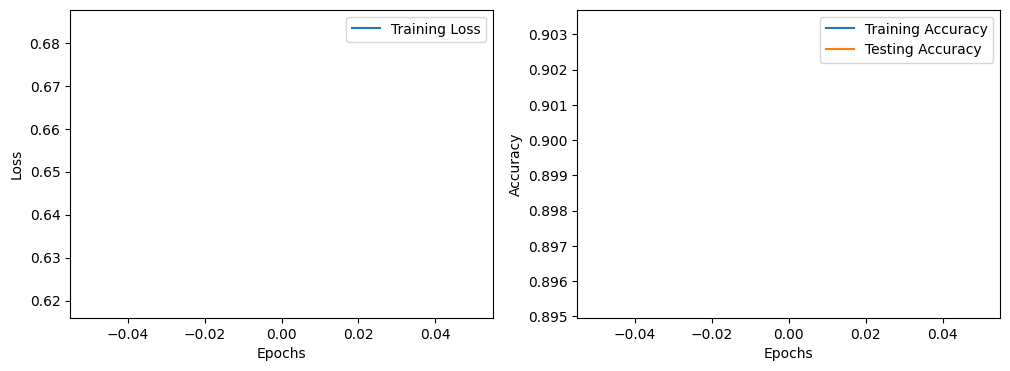

In [398]:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
#     plt.plot(test_loss, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(test_acc, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()